In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os, cv2
import tensorflow as tf
from tqdm import tqdm
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from skimage.util import random_noise
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
EPOCHS = 40
NOISE_FACTOR = 0.3
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

In [3]:
# Définitions des répertoire 
PATH_MODEL_SAVE = './PATH_MODEL_SAVE'
PATH_DATASET ='../Dataset2'
#PATH_GAUSSIAN_BLURRED = './Blurred_j'
#PATH_GAUSSIAN_NOISED ='./Noisy_j'

#if not os.path.exists(PATH_GAUSSIAN_BLURRED):
 #   os.makedirs(PATH_GAUSSIAN_BLURRED)
    
#if not os.path.exists(PATH_GAUSSIAN_NOISED):
 #   os.makedirs(PATH_GAUSSIAN_NOISED)

In [4]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
    color_mode='rgb'
)

x_train, _ = iter(dataset_train).next()
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

dataset_test = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
    color_mode='rgb'
)

x_test, _ = iter(dataset_test).next()
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

print(x_train.shape)
print(x_test.shape)

Found 4009 files belonging to 1 classes.
Using 3208 files for training.
Found 4009 files belonging to 1 classes.
Using 801 files for validation.
(32, 256, 256, 3)
(32, 256, 256, 3)


In [5]:
# Définition des jeux de test et validation
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) * NOISE_FACTOR
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) * NOISE_FACTOR

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [6]:
# Fonction qui va afficher nos images 
def display_image(X, n):
    plt.figure(figsize = (32, 32))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

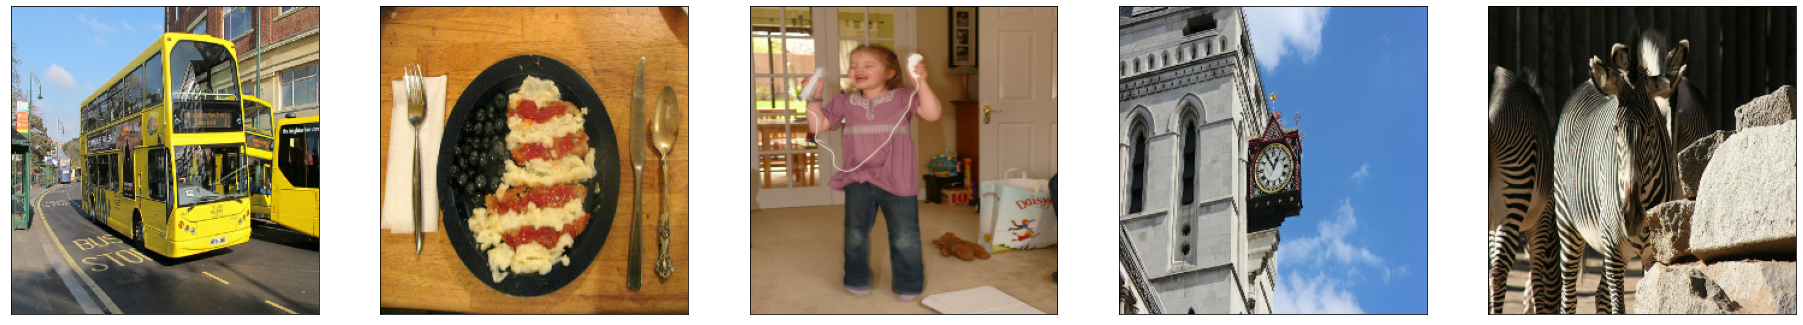

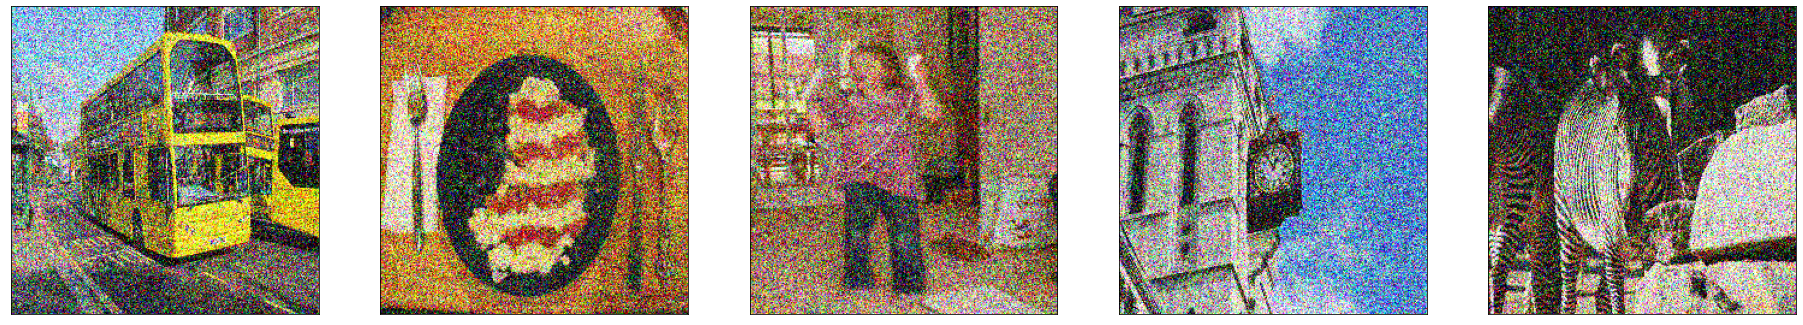

In [7]:
# On affiche les images normales 
display_image(x_train, n = 5)
# On afficher les images bruitées 
display_image(x_train_noisy, n = 5)

In [8]:
INPUT_SHAPE = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), name="input")
# ENCODING
# Convolution 1
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name="conv_1_encoder")(INPUT_SHAPE)
x = MaxPooling2D((2, 2), padding="same", name="pooling_1")(x)

# Convolution 2
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name="conv_2_encoder")(x)
x = MaxPooling2D((2, 2), padding="same", name="pooling_2")(x)

# Convolution 3
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name="conv_3_encoder")(x)
#x = MaxPooling2D((2, 2), padding="same", name="pooling_3")(x)

# Convolution 4
#x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_4_encoder")(x)

encode = MaxPooling2D(pool_size=(2, 2), padding="same", name="pooling_3")(x)


In [9]:
# DECODING
# Déconvolution 1
#x = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu', name="conv_1_decoder")(encode)
#x = UpSampling2D((2, 2), name="sampling_1")(x)

# Déconvolution 2
x = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_2_decoder")(encode)
#x = UpSampling2D((2, 2), name="sampling_2")(x)

# Déconvolution 3
x = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_3_decoder")(x)
#x = UpSampling2D((2, 2), name="sampling_3")(x)

# Déconvolution 4
x = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_4_decoder")(x)
#x = UpSampling2D((2, 2), name="sampling_4")(x)
 
# Output    
decode = Conv2D(3, (3, 3),  padding="same", activation="sigmoid", name="output")(x)

In [10]:
#Définition de l'autoencoder et compilation du modèle 
autoencoder = Model(INPUT_SHAPE, decode, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv_1_encoder (Conv2D)     (None, 256, 256, 32)      896       
                                                                 
 pooling_1 (MaxPooling2D)    (None, 128, 128, 32)      0         
                                                                 
 conv_2_encoder (Conv2D)     (None, 128, 128, 64)      18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 64, 64, 64)        0         
                                                                 
 conv_3_encoder (Conv2D)     (None, 64, 64, 128)       73856     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 32, 32, 128)       

In [11]:
#On entraine l'autoencoder
history = autoencoder.fit(x_train_noisy, x_train, epochs= EPOCHS, batch_size = BATCH_SIZE, 
                          shuffle = True, validation_data = (x_test_noisy, x_test))

Epoch 1/40
1/1 [==============================] - 5s 5s/step - loss: 0.0811 - accuracy: 0.3628 - val_loss: 0.0797 - val_accuracy: 0.3701
Epoch 2/40
1/1 [==============================] - 5s 5s/step - loss: 0.0809 - accuracy: 0.3812 - val_loss: 0.0793 - val_accuracy: 0.3611
Epoch 3/40
1/1 [==============================] - 5s 5s/step - loss: 0.0806 - accuracy: 0.3776 - val_loss: 0.0786 - val_accuracy: 0.3415
Epoch 4/40
1/1 [==============================] - 5s 5s/step - loss: 0.0801 - accuracy: 0.3657 - val_loss: 0.0777 - val_accuracy: 0.3404
Epoch 5/40
1/1 [==============================] - 4s 4s/step - loss: 0.0795 - accuracy: 0.3644 - val_loss: 0.0765 - val_accuracy: 0.3516
Epoch 6/40
1/1 [==============================] - 5s 5s/step - loss: 0.0787 - accuracy: 0.3709 - val_loss: 0.0753 - val_accuracy: 0.3851
Epoch 7/40
1/1 [==============================] - 5s 5s/step - loss: 0.0779 - accuracy: 0.3918 - val_loss: 0.0738 - val_accuracy: 0.4034
Epoch 8/40
1/1 [=========================

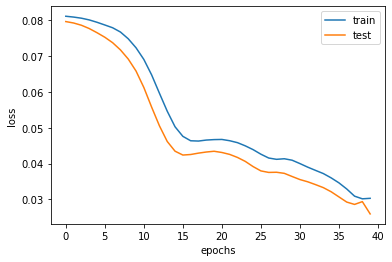

In [12]:
# On affiche les courbes loss du train et test 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel(list(history.history.keys())[0])
plt.show()

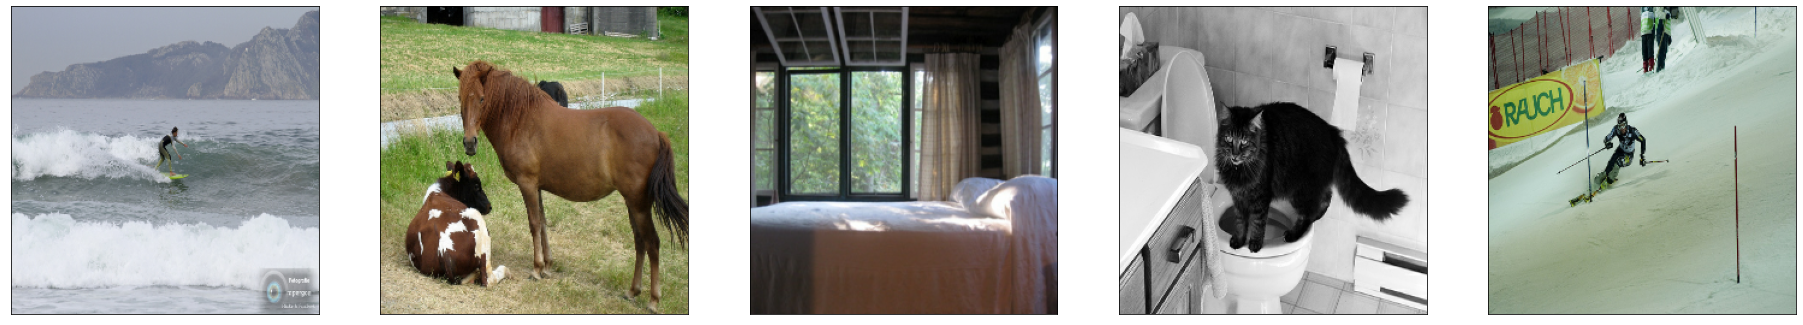

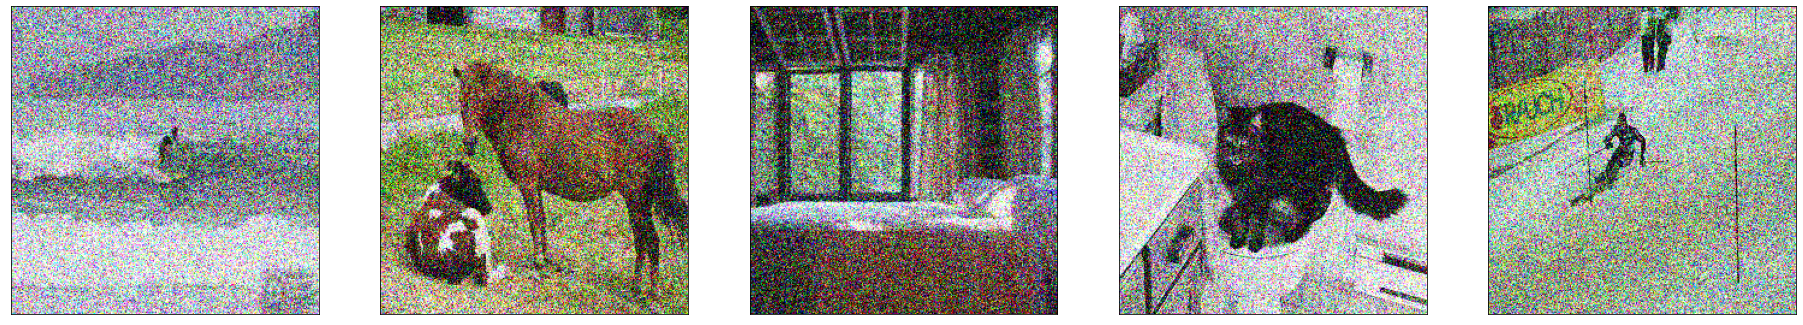

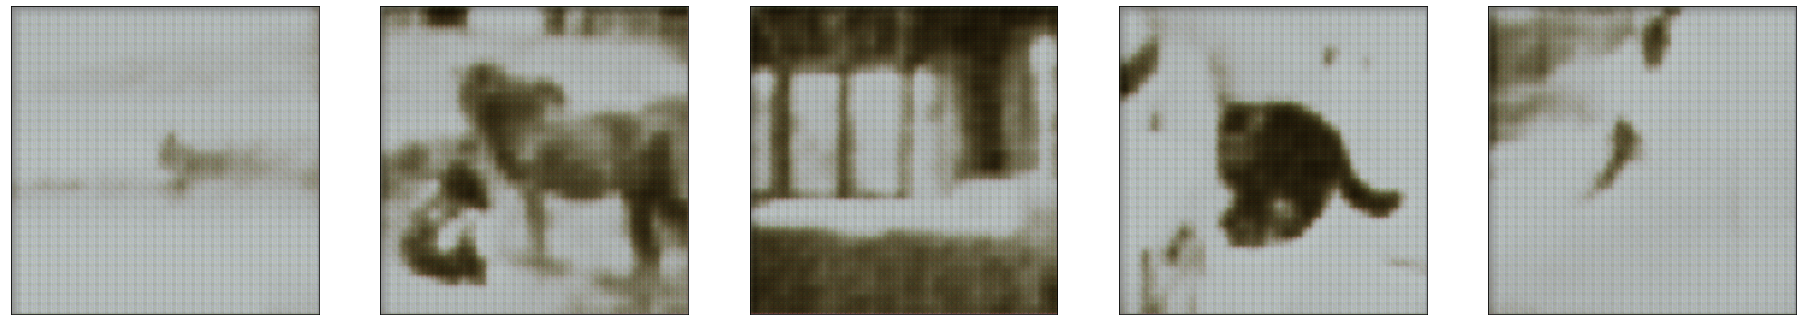

In [13]:
predictions = autoencoder.predict(x_test_noisy)
display_image(x_test, n=5)
display_image(x_test_noisy, n=5)
display_image(predictions, n=5)

In [14]:
# On sauvegarde le modèle pour le réutiliser
autoencoder.save('PATH_MODEL_SAVE')
model = tf.keras.models.load_model(PATH_MODEL_SAVE)

INFO:tensorflow:Assets written to: PATH_MODEL_SAVE\assets


In [15]:
# On met l'image de test dans le bon format
input_img = PIL.Image.open('./images2.jpg').convert('RGB')
input_img = input_img.resize((256, 256), PIL.Image.ANTIALIAS)
input_img = np.array(input_img, dtype=np.float32)
input_img = input_img.astype('float32')/255
input_img = tf.expand_dims(input_img, axis=0)

FileNotFoundError: [Errno 2] No such file or directory: './images2.jpg'

In [ ]:
# Prédire une version débruité
denoised = model.predict(input_img)
display_image(denoised, n=1)